<a href="https://colab.research.google.com/github/jaiyue/coursera-Data-Analysis-of-Police-Records/blob/main/Data_Analysis_of_Police_Records.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Upload 911.csv

In [ ]:
from google.colab import files

uploaded = files.upload()

Saving 911.csv to 911 (1).csv


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

df = pd.read_csv("911.csv")

conn = sqlite3.connect(":memory:")
df.to_sql("calls_911", conn, if_exists="replace", index=False)

print(df.head())
# Data volume
print("Rows:", len(df))
print("Columns:", df.shape[1])

# Field names
print("\nColumns:")
print(list(df.columns))

# Data types
print("\nData types:")
df.info()

# Dummy variable check
print("\nDummy variable (e):")
print(df["e"].value_counts())

# Missing values
print("\nMissing values:")
print(df.isnull().sum())

         lat        lng                                               desc  \
0  40.297876 -75.581294  REINDEER CT & DEAD END;  NEW HANOVER; Station ...   
1  40.258061 -75.264680  BRIAR PATH & WHITEMARSH LN;  HATFIELD TOWNSHIP...   
2  40.121182 -75.351975  HAWS AVE; NORRISTOWN; 2015-12-10 @ 14:39:21-St...   
3  40.116153 -75.343513  AIRY ST & SWEDE ST;  NORRISTOWN; Station 308A;...   
4  40.251492 -75.603350  CHERRYWOOD CT & DEAD END;  LOWER POTTSGROVE; S...   

       zip                    title            timeStamp                twp  \
0  19525.0   EMS: BACK PAINS/INJURY  2015-12-10 17:10:52        NEW HANOVER   
1  19446.0  EMS: DIABETIC EMERGENCY  2015-12-10 17:29:21  HATFIELD TOWNSHIP   
2  19401.0      Fire: GAS-ODOR/LEAK  2015-12-10 14:39:21         NORRISTOWN   
3  19401.0   EMS: CARDIAC EMERGENCY  2015-12-10 16:47:36         NORRISTOWN   
4      NaN           EMS: DIZZINESS  2015-12-10 16:56:52   LOWER POTTSGROVE   

                         addr  e  
0      REINDEER CT & 

Remove duplicated rows

In [ ]:
print(df.duplicated().sum())
df = df.drop_duplicates()
print(df.duplicated().sum())

59
0


Parse timestamp and count invalid entries

In [ ]:
df["timeStamp"] = pd.to_datetime(df["timeStamp"], errors="coerce")
print("Invalid timestamps (NaT):")
print(df["timeStamp"].isna().sum())
df["DayOfWeek"] = df["timeStamp"].dt.day_name()
df["Month"] = df["timeStamp"].dt.month
df["Date"] = df["timeStamp"].dt.date
day_order = [
    "Monday", "Tuesday", "Wednesday",
    "Thursday", "Friday", "Saturday", "Sunday"
]

df["DayOfWeek"] = pd.Categorical(
    df["DayOfWeek"],
    categories=day_order,
    ordered=True
)
print("\nDayOfWeek sample:")
print(df["DayOfWeek"].unique()[:5])

print("\nMonth sample:")
print(df["Month"].unique()[:5])

print("\nDate sample:")
print(df["Date"].unique()[:5])

Invalid timestamps (NaT):
0

DayOfWeek sample:
['Thursday', 'Friday', 'Saturday', 'Sunday', 'Monday']
Categories (7, object): ['Monday' < 'Tuesday' < 'Wednesday' < 'Thursday' < 'Friday' < 'Saturday' <
                         'Sunday']

Month sample:
[12  1  2  3  4]

Date sample:
[datetime.date(2015, 12, 10) datetime.date(2015, 12, 11)
 datetime.date(2015, 12, 12) datetime.date(2015, 12, 13)
 datetime.date(2015, 12, 14)]


Convert zip to string type

In [ ]:
df["zip"] = df["zip"].astype("Int64").astype(str)
df["zip"].dtype
df["zip"] = df["zip"].replace("<NA>", pd.NA)

Create Reason col from title


In [41]:
df["Reason"] = df["title"].str.split(":").str[0]
reason_counts = df["Reason"].value_counts()
print(df["Reason"].unique())

['EMS' 'Fire' 'Traffic']


Compute-- What are the top 10 Zipcodes for 911& Question 1: Are Zipcodes 19446 and 19090 present ?

In [39]:
query_top10 = """
SELECT zip, COUNT(*) AS cnt
FROM calls_911
WHERE zip IS NOT NULL
GROUP BY zip
ORDER BY cnt DESC
LIMIT 10;
"""

top10_zip_sql = pd.read_sql(query_top10, conn)

print("Top 10 Zipcodes:")
print(top10_zip_sql.to_string(index=False))

#Part 2
query_check = """
SELECT DISTINCT zip
FROM calls_911
WHERE zip IN (19446, 19090);
"""
print("The following zip(s) exist:")
print(pd.read_sql(query_check, conn).to_string(index=False))

Top 10 Zipcodes:
    zip   cnt
19401.0 18401
19464.0 17937
19403.0 13366
19446.0 12828
19406.0  8820
19002.0  8367
19468.0  7860
19046.0  7340
19454.0  7274
19090.0  6999
The following zip(s) exist:
    zip
19446.0
19090.0


Compute --What are the top 4 townships (twp) for 911 calls& Question 2: Whichof the following township arenot present? -- LOWER POTTSGROVE, NORRISTOWN, HORSHAM, ABINGTON

In [40]:
query_top4_twp = """
SELECT twp, COUNT(*) AS cnt
FROM calls_911
WHERE twp IS NOT NULL
GROUP BY twp
ORDER BY cnt DESC
LIMIT 4;
"""

top4 = pd.read_sql(query_top4_twp, conn)

print("Top 4 townships:")
print(top4.to_string(index=False))

query_check = """
SELECT DISTINCT UPPER(twp) AS twp
FROM calls_911
WHERE UPPER(twp) IN (
    'LOWER POTTSGROVE',
    'NORRISTOWN',
    'HORSHAM',
    'ABINGTON'
);
"""

present_df = pd.read_sql(query_check, conn)
present = set(present_df["twp"])
given = ["LOWER POTTSGROVE", "NORRISTOWN", "HORSHAM", "ABINGTON"]

print("\nTownship presence check:")
print(pd.read_sql(query_check, conn).to_string(index=False))

Top 4 townships:
         twp   cnt
LOWER MERION 22886
    ABINGTON 16379
  NORRISTOWN 15421
UPPER MERION 14015

Township presence check:
             twp
      NORRISTOWN
LOWER POTTSGROVE
         HORSHAM
        ABINGTON


Compute -- Create new features& Question 3: What is the most common Reason for a 911 call based on Reason Column? Which comes second

In [42]:
print("911 call reasons (top 2):")
print(reason_counts.head(2).to_string())

911 call reasons (top 2):
Reason
EMS        133207
Traffic     93380


Compute -- Plot barchart using matplotfor 911 calls by Reason& Question 4: How can you plot the bars horizontally ?

*   Using barh



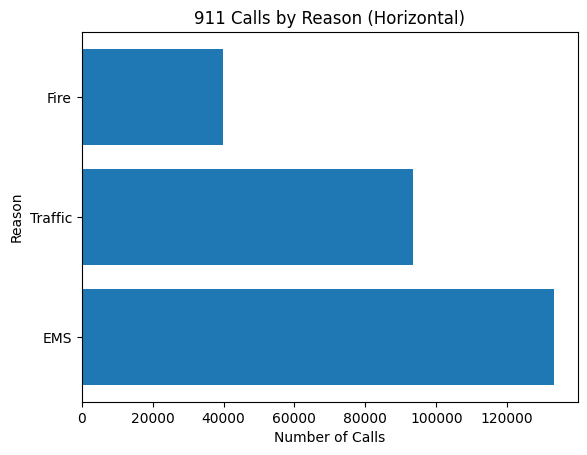

In [43]:
plt.figure()
plt.barh(reason_counts.index, reason_counts.values)
plt.xlabel("Number of Calls")
plt.ylabel("Reason")
plt.title("911 Calls by Reason (Horizontal)")
plt.show()

Do data manipulation & Question 5: Which day got maximum calls for EMS and how many?

In [44]:
ems_df = df[df["Reason"] == "EMS"]
ems_by_day = ems_df["Date"].value_counts()
max_day = ems_by_day.idxmax()
max_count = ems_by_day.max()

print("Day with maximum EMS calls:")
print(f"{max_day} with {max_count} calls")

Day with maximum EMS calls:
2016-01-24 with 250 calls


Compute -- Create a countplot of the Day of Week column with the hue based of the Reason column & Question 6: On which day traffic calls were lowest ?

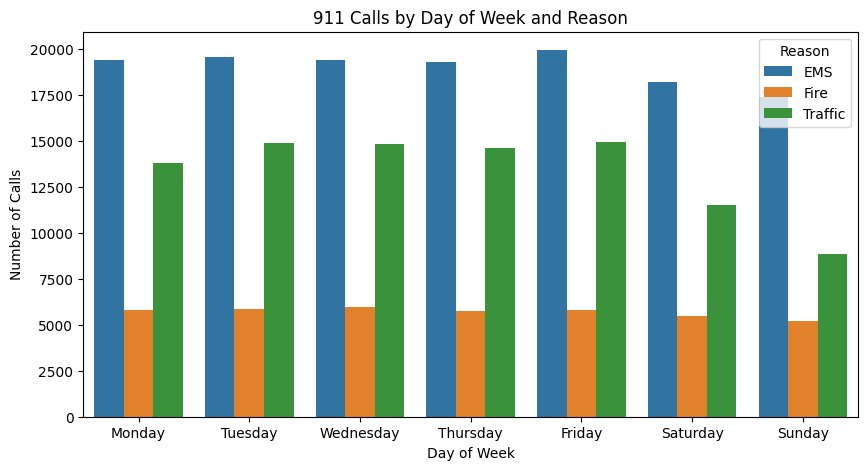

Day with lowest traffic calls:
Sunday with 8843 calls


In [45]:
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x="DayOfWeek", hue="Reason")
plt.xlabel("Day of Week")
plt.ylabel("Number of Calls")
plt.title("911 Calls by Day of Week and Reason")
plt.show()

traffic_df = df[df["Reason"] == "Traffic"]
traffic_by_day = traffic_df["DayOfWeek"].value_counts().sort_index()
min_day = traffic_by_day.idxmin()
min_count = traffic_by_day.min()

print("Day with lowest traffic calls:")
print(f"{min_day} with {min_count} calls")


Compute -- Create a countplot month wise-- Question 7: Which month saw highest calls for fire?

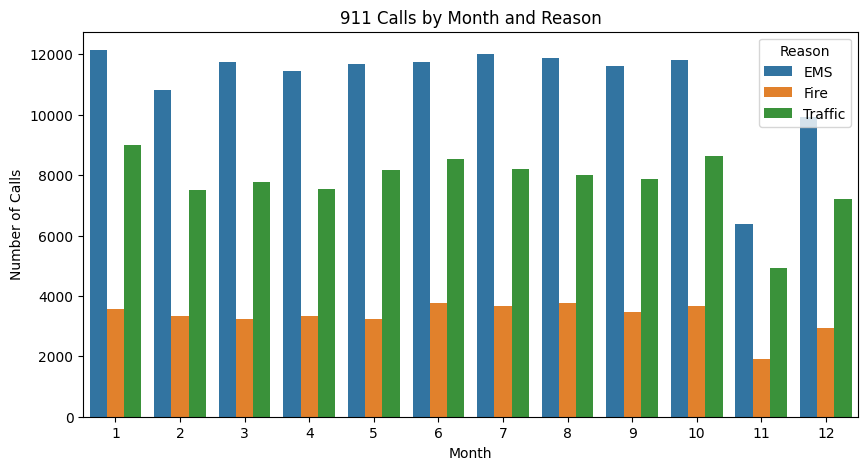

Month with highest fire calls:
Month 6 with 3773 calls


In [47]:
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x="Month", hue="Reason")
plt.xlabel("Month")
plt.ylabel("Number of Calls")
plt.title("911 Calls by Month and Reason")
plt.show()

fire_df = df[df["Reason"] == "Fire"]
fire_by_month = fire_df["Month"].value_counts().sort_index()
max_month = fire_by_month.idxmax()
max_count = fire_by_month.max()

print("Month with highest fire calls:")
print(f"Month {max_month} with {max_count} calls")
